# Isotropic viscosity inversion of ice shelves via PINNs

Fast running the code requires **GPU hardware** to accelerate.

To choose GPU hardware, click the "Edit" in the toolbar above and select "Notebook settings".

In the pop-up window, under the "Hardware accelerator", select "T4 GPU"

To ensure the code to run correctly in the colab, install the specific version of JAX below.

(Note that only using the GPU version of JAX, combined with the selection of GPU hardware as mentioned above, can eventually accelerate the training.)

Copying required python functions from the [DIFFICE_jax](https://github.com/YaoGroup/DIFFICE_jax) GitHub repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the DIFFICE_jax
!pip install DIFFICE_jax

# download the data from GitHub respository
!wget https://github.com/YaoGroup/DIFFICE_jax/raw/main/examples/real_data/data_pinns_Amery.mat


--2025-06-16 20:46:26--  https://github.com/YaoGroup/DIFFICE_jax/raw/main/examples/real_data/data_pinns_Amery.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YaoGroup/DIFFICE_jax/main/examples/real_data/data_pinns_Amery.mat [following]
--2025-06-16 20:46:27--  https://raw.githubusercontent.com/YaoGroup/DIFFICE_jax/main/examples/real_data/data_pinns_Amery.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228601 (2.1M) [application/octet-stream]
Saving to: ‘data_pinns_Amery.mat’

data_pinns_Amery.ma 100%[===================>]   2.12M  --.-KB/s    in 0.01s   

2025-06-16 20:46:27 (213 MB

Importing the required JAX library and function file from GitHub repository

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time
import geopandas as gpd
import os
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from matplotlib.path import Path
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
from mpl_toolkits.axes_grid1 import make_axes_locatable

from diffice_jax import normdata_pinn, dsample_pinn
from diffice_jax import vectgrad, ssa_iso, dbc_iso
from diffice_jax import init_pinn, solu_pinn
from diffice_jax import loss_iso_pinn
from diffice_jax import predict_pinn
from diffice_jax import adam_opt, lbfgs_opt

from matplotlib.colors import LogNorm
import imageio
import glob
import matplotlib.animation as animation
from matplotlib.image import imread

In [ ]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/amery/PINNplots_bedmap'
os.makedirs(output_dir, exist_ok=True)

# Setting hyperparameters

hyper-parameters used for the training. Users are free to modify their value and check their influence on the training results


In [ ]:
# select a random seed
seed = 2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 6
n_unit = 30
# set the weight for 1. equation loss and 2. boundary condition loss
lw = [0.05, 0.1]

# number of sampling points
n_smp = 5000    # for velocity data
nh_smp = 4500   # for thickness data
n_col = 5000    # for collocation points
n_cbd = 400     # for boundary condition (calving front)
# group all the number of points
n_pt = jnp.array([n_smp, nh_smp, n_col, n_cbd], dtype='int32')
# double the points for L-BFGS training
n_pt2 = n_pt * 2

# Data Loading
load and normalize tne observed data before the PINN training

In [ ]:
# load .mat data (from real data in diffice-jax)
rawdata = loadmat('data_pinns_Amery.mat')
xd = rawdata['xd']
yd = rawdata['yd']
hd_orig = rawdata['hd']  # original ice thickness, will replace with bedmap

In [ ]:
# load bedmap data
folder = os.path.expanduser("/content/drive/MyDrive/Colab Notebooks/amery/bedmap_data")
gpq_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.gpq')]
bedmap_points = gpd.GeoDataFrame(pd.concat([gpd.read_parquet(f) for f in gpq_files], ignore_index=True))
bedmap_points = bedmap_points.dropna(subset=['Mean_thick'])

In [ ]:
# extract coordinates and thickness
# ensure CRS is set
if bedmap_points.crs is None:
    bedmap_points.set_crs(epsg=4326, inplace=True)
# reproject to polar stereographic (to match DIFFICE grid)
bedmap_proj = bedmap_points.to_crs(epsg=3031)  # EPSG:3031 = Antarctic Polar Stereographic
x_bedmap = bedmap_proj.geometry.x.values
y_bedmap = bedmap_proj.geometry.y.values
thickness_bedmap = bedmap_proj['Mean_thick'].values

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


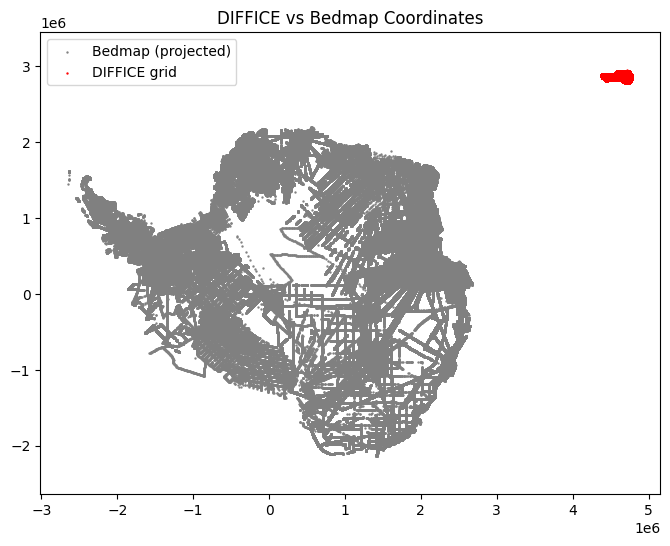

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_bedmap, y_bedmap, c='gray', s=0.5, label='Bedmap (projected)')
plt.scatter(xd.ravel(), yd.ravel(), c='red', s=0.5, label='DIFFICE grid')
plt.title("DIFFICE vs Bedmap Coordinates")
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
# Current DIFFICE (unshifted) bounds
x_min_dif, x_max_dif = np.nanmin(xd), np.nanmax(xd)
y_min_dif, y_max_dif = np.nanmin(yd), np.nanmax(yd)

# Bedmap bounds (already reprojected to EPSG:3031)
x_min_bed, x_max_bed = np.min(x_bedmap), np.max(x_bedmap)
y_min_bed, y_max_bed = np.min(y_bedmap), np.max(y_bedmap)

print("DIFFICE grid (xd, yd) range:")
print(f"  x: {x_min_dif:.1f} to {x_max_dif:.1f}")
print(f"  y: {y_min_dif:.1f} to {y_max_dif:.1f}")

print("Bedmap full range:")
print(f"  x: {x_min_bed:.1f} to {x_max_bed:.1f}")
print(f"  y: {y_min_bed:.1f} to {y_max_bed:.1f}")

DIFFICE grid (xd, yd) range:
  x: 4378250.0 to 4782800.0
  y: 2779200.0 to 2944350.0
Bedmap full range:
  x: -2644750.0 to 2677250.0
  y: -2132750.0 to 2201750.0


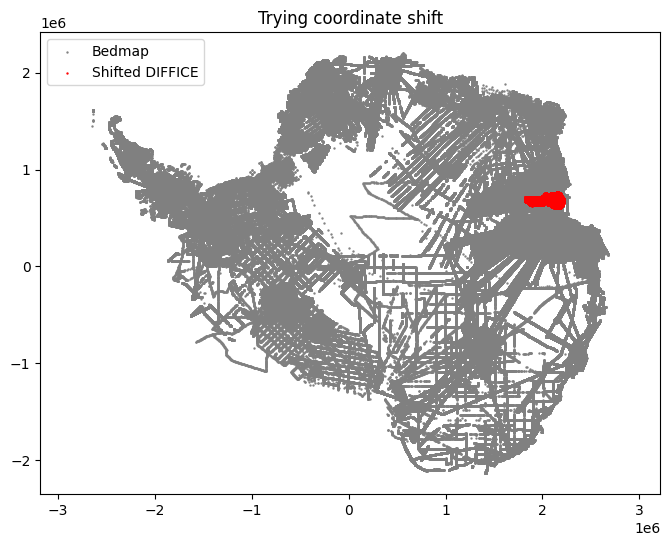

In [ ]:
# shift diffice grid to match bedmap data bounds properly
xd_shifted = xd - 2_560_000
yd_shifted = yd - 2_180_000

plt.figure(figsize=(8, 6))
plt.scatter(x_bedmap, y_bedmap, c='gray', s=0.5, label='Bedmap')
plt.scatter(xd_shifted.ravel(), yd_shifted.ravel(), c='red', s=0.5, label='Shifted DIFFICE')
plt.legend()
plt.axis('equal')
plt.title("Coordinate shift")
plt.show()

In [ ]:
# Get valid bounding box of Amery grid
xd_shifted = xd - 2_560_000
yd_shifted = yd - 2_160_000

# Use the shifted bounding box to crop Bedmap points
margin = 10_000  # 10 km extra buffer
x_min = np.nanmin(xd_shifted) - margin
x_max = np.nanmax(xd_shifted) + margin
y_min = np.nanmin(yd_shifted) - margin
y_max = np.nanmax(yd_shifted) + margin

# Crop Bedmap points to that bounding box
in_bounds = ((x_bedmap >= x_min) & (x_bedmap <= x_max) &
    (y_bedmap >= y_min) & (y_bedmap <= y_max))

# Keep only valid thickness values within Amery bounds
valid_bedmap = (thickness_bedmap > 5) & in_bounds
x_bedmap_valid = x_bedmap[valid_bedmap]
y_bedmap_valid = y_bedmap[valid_bedmap]
thickness_valid = thickness_bedmap[valid_bedmap]
points_bedmap = np.column_stack((x_bedmap_valid, y_bedmap_valid))

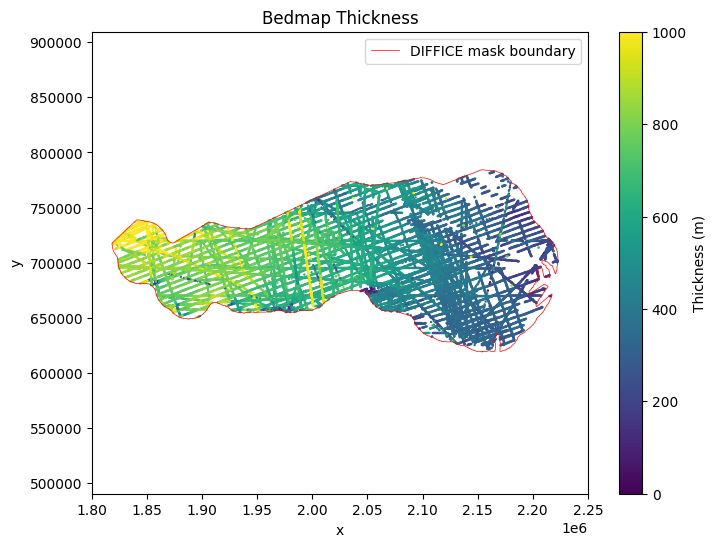

In [ ]:
from shapely.geometry import Polygon, Point
from skimage.measure import find_contours

# Step 1: Create a binary mask of the DIFFICE domain
# Assume some DIFFICE field (like mu, or u) exists with NaNs outside the domain
mask = np.isfinite(xd_shifted.reshape(xd.shape))  # or use e.g. mu or u if available

# Step 2: Use skimage to extract the boundary of the mask
contours = find_contours(mask.astype(float), level=0.5)

# Step 3: Use the longest contour (most complete boundary)
longest = max(contours, key=len)
i, j = longest[:, 0], longest[:, 1]  # row, col indices

# Step 4: Map array indices back to x/y coordinates
x_outline = xd_shifted.reshape(xd.shape)[i.astype(int), j.astype(int)]
y_outline = yd_shifted.reshape(yd.shape)[i.astype(int), j.astype(int)]

# Remove any NaNs
valid = np.isfinite(x_outline) & np.isfinite(y_outline)
x_outline = x_outline[valid]
y_outline = y_outline[valid]

# Step 5: Create polygon from outline
outline_coords = np.column_stack((x_outline, y_outline))
diffice_polygon = Polygon(outline_coords)

# Step 6: Convert Bedmap points to GeoDataFrame
bedmap_gdf = gpd.GeoDataFrame(
    {'thickness': thickness_bedmap},
    geometry=gpd.points_from_xy(x_bedmap, y_bedmap),
    crs="EPSG:3031"
)

# Step 7: Mask Bedmap points spatially
in_amery_mask = bedmap_gdf.within(diffice_polygon)
bedmap_amery = bedmap_gdf[in_amery_mask & (bedmap_gdf['thickness'] > 5)]

# Step 8: Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    bedmap_amery.geometry.x, bedmap_amery.geometry.y,
    c=bedmap_amery['thickness'], s=0.5, vmin=0, vmax=1000, cmap='viridis'
)
plt.plot(x_outline, y_outline, color='red', linewidth=0.5, label='DIFFICE mask boundary')
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(1.8e6, 2.25e6)
plt.ylim(550000, 850000)
plt.colorbar(label="Thickness (m)")
plt.legend()
plt.title("Bedmap Thickness")
#plt.savefig(f"{output_dir}/raw_bedmap_thickness_cropped.png")
plt.show()

In [ ]:
# Use raw ICESat-2 track points for thickness data
rawdata['hd'] = bedmap_amery['thickness'].values.reshape(-1, 1)
rawdata['xd_h'] = bedmap_amery.geometry.x.values.reshape(-1, 1)
rawdata['yd_h'] = bedmap_amery.geometry.y.values.reshape(-1, 1)

In [ ]:
# normalize and prep for PINN training
data_all = normdata_pinn(rawdata)
scale = data_all[4][0:2]

In [ ]:
# create functions to save plotted snapshots of inferred viscosity and residuals during each XX iteration of PINN training
# and to animate these into a video later

def save_training_snapshots(params, data_all, grid_shape, xd, yd, output_dir, iteration, method_name, scale):
    """Save training snapshots including viscosity and residual plots"""
    try:
        # Create the function group needed for predict_pinn (same as your working code)
        f_u = lambda x: pred_u(params, x)
        f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:6]
        func_all = (f_u, f_gu, ssa_iso)

        # Get current predictions using predict_pinn (same as your working code)
        results = predict_pinn(func_all, data_all)

        # Save viscosity snapshot (using 'mu' key like in your working code)
        try:
            viscosity = results['mu']
            viscosity_reshaped = viscosity.reshape(grid_shape)

            # Handle NaN/Inf by computing color limits from finite values only
            finite_mask = np.isfinite(viscosity_reshaped)
            if finite_mask.any():
                vmin = np.min(viscosity_reshaped[finite_mask])
                vmax = np.max(viscosity_reshaped[finite_mask])
            else:
                print(f"Warning: All viscosity values are NaN/Inf at iteration {iteration}")
                vmin, vmax = 0, 1  # fallback values

            fig, ax = plt.subplots(figsize=(10, 5), dpi=70)
            h = ax.imshow(viscosity_reshaped, interpolation='nearest', cmap='rainbow',
                          extent=[0., 50000., 0,  80000.],
                          origin='lower', aspect='auto',
                          vmin=vmin, vmax=vmax)  # Use computed finite limits
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="4%", pad=0.05)
            fig.colorbar(h, cax=cax)
            ax.set_xlabel('$x$', fontsize=15)
            ax.set_ylabel('$y\ $', fontsize=15, rotation=0)
            ax.set_title(f'Inferred viscosity $\mu(x,y)$ - {method_name} Iteration {iteration}', fontsize=15)
            fig.savefig(f"{output_dir}/mu_e1_e2_snaps/viscosity_{method_name}_iter_{iteration}.png", dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"Saved viscosity at iteration {iteration}")
        except Exception as e:
            print(f"Failed to save viscosity at iteration {iteration}: {e}")

        # Save residual snapshots with FIXED COLOR LIMITS
        residual_keys = ['e1', 'e2']
        for key in residual_keys:
            if key in results:
                try:
                    residual = results[key]
                    reshaped = residual.reshape(grid_shape)

                    # Check if xd and yd have valid extents
                    if not (np.isfinite(xd.min()) and np.isfinite(xd.max()) and
                            np.isfinite(yd.min()) and np.isfinite(yd.max())):
                        print(f"Warning: xd/yd contains NaN/Inf at iteration {iteration}")
                        extent = [0, 1, 0, 1]  # fallback extent
                    else:
                        extent = [xd.min(), xd.max(), yd.min(), yd.max()]

                    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
                    # Use FIXED color limits to avoid NaN/Inf issues completely
                    h = ax.imshow(reshaped, interpolation='nearest', cmap='RdBu_r',
                                  extent=extent,
                                  origin='lower', aspect='auto',
                                  vmin=-1000, vmax=1000)  # FIXED LIMITS
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="4%", pad=0.05)
                    fig.colorbar(h, cax=cax)
                    ax.set_title(f'{key} Residual - {method_name} Iteration {iteration}', fontsize=14)
                    ax.set_xlabel('x')
                    ax.set_ylabel('y')
                    fig.savefig(f"{output_dir}/mu_e1_e2_snaps/{key}_residual_{method_name}_iter_{iteration}.png", dpi=300, bbox_inches='tight')
                    plt.close(fig)
                    print(f"Saved {key} residual at iteration {iteration}")
                except Exception as e:
                    print(f"Failed to save {key} residual at iteration {iteration}: {e}")

        print(f"Saved snapshots for {method_name} iteration {iteration}")

    except Exception as e:
        print(f"Error saving snapshots at iteration {iteration}: {e}")
        import traceback
        traceback.print_exc()  # This will show exactly where the error occurs

def create_animation_gifs(output_dir):
    """
    Create GIF animations from saved frames
    """
    animation_dir = f"{output_dir}/animation_frames"

    # Create viscosity animation
    viscosity_files = sorted(glob.glob(f"{animation_dir}/viscosity_*.png"))
    if viscosity_files:
        images = []
        for filename in viscosity_files:
            images.append(imageio.imread(filename))
        imageio.mimsave(f"{output_dir}/viscosity_evolution.gif", images, duration=0.5)
        print(f"Created viscosity animation with {len(images)} frames")

    # Create residual animations
    for residual in ['e1', 'e2']:
        residual_files = sorted(glob.glob(f"{animation_dir}/{residual}_*.png"))
        if residual_files:
            images = []
            for filename in residual_files:
                images.append(imageio.imread(filename))
            imageio.mimsave(f"{output_dir}/{residual}_residual_evolution.gif", images, duration=0.5)
            print(f"Created {residual} residual animation with {len(images)} frames")

# Create directory for animation frames
os.makedirs(f"{output_dir}/animation_frames", exist_ok=True)

# Initialization

initialize the neural network and loss function

In [ ]:
# initialize the weights and biases of the network
trained_params = init_pinn(keys[0], n_hl, n_unit)

# create the solution function
pred_u = solu_pinn()

# create the data sampling function for Adam training
dataf = dsample_pinn(data_all, n_pt)
keys_adam = random.split(keys[1], 5)
# generate the data
data = dataf(keys_adam[0])

# create the data sampling function for L-BFGS training
dataf_l = dsample_pinn(data_all, n_pt2)
key_lbfgs = random.split(keys[2], 5)

# group the gov. eqn and bdry cond.
eqn_all = (ssa_iso, dbc_iso)
# create the loss function
NN_loss = loss_iso_pinn(pred_u, eqn_all, scale, lw)
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

# Network training

Since the real ice shelf data has more complicated profile than the synthetic data. 10000 iterations of Adam, followed by another 10000 iterations of L-BFGS can only infer a **very rough** profile of the ice viscosity.

To train a high-accurate model, the number of iterations required for both Adam and L-BFGS optimization is more than 100k.


In [ ]:
# modified adam training

# Define grid shape from your existing xd, yd arrays
grid_shape = xd.shape

# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000
snapshot_interval = 100  # Save every 100 iterations

print("Starting Adam training with snapshots...")

# Initialize for Adam training

# Use existing adam_opt but with snapshot functionality
# --> modify the training to save snapshots during the existing adam_opt call

# Save initial snapshot
save_training_snapshots(trained_params, data_all, grid_shape, xd, yd, output_dir, 0, "Adam", scale)

# Create a custom callback version that saves snapshots
# Since adam_opt doesn't support callbacks, we'll use a wrapper approach
def adam_with_snapshots(key, loss_fn, init_params, data_fn, epochs, lr):
    # Use smaller chunks and save periodically
    chunk_size = snapshot_interval
    current_params = init_params
    all_losses = []

    total_iterations = 0

    for chunk_start in range(0, epochs, chunk_size):
        chunk_epochs = min(chunk_size, epochs - chunk_start)

        # Train for this chunk
        current_params, chunk_losses = adam_opt(key, loss_fn, current_params, data_fn, chunk_epochs, lr=lr)
        all_losses.extend(chunk_losses)

        total_iterations += chunk_epochs

        # Save snapshot after each chunk
        save_training_snapshots(current_params, data_all, grid_shape, xd, yd,
                              output_dir, total_iterations, "Adam", scale)

        print(f"Adam progress: {total_iterations}/{epochs} iterations completed")

        # Generate new key for next chunk
        key, _ = random.split(key)

    return current_params, all_losses

# Run Adam training with snapshots
trained_params, loss1 = adam_with_snapshots(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr)

Step: 100 | Loss: 1.3130e-01 | Loss_d: 1.5282e-01 | Loss_e: 4.2041e-02 | Loss_b: 2.1018e-03
Step: 200 | Loss: 7.3740e-02 | Loss_d: 7.7128e-02 | Loss_e: 1.8367e-01 | Loss_b: 8.1467e-03
Step: 300 | Loss: 4.6223e-02 | Loss_d: 4.7686e-02 | Loss_e: 1.1539e-01 | Loss_b: 1.1584e-02
Step: 400 | Loss: 3.3964e-02 | Loss_d: 3.5391e-02 | Loss_e: 7.3716e-02 | Loss_b: 1.0527e-02
Step: 500 | Loss: 3.0425e-02 | Loss_d: 3.2605e-02 | Loss_e: 4.6521e-02 | Loss_b: 1.0173e-02
Step: 600 | Loss: 2.7900e-02 | Loss_d: 3.0312e-02 | Loss_e: 3.1660e-02 | Loss_b: 1.0705e-02
Step: 700 | Loss: 2.7138e-02 | Loss_d: 2.9357e-02 | Loss_e: 3.4140e-02 | Loss_b: 1.0001e-02
Step: 800 | Loss: 2.5832e-02 | Loss_d: 2.7691e-02 | Loss_e: 3.8291e-02 | Loss_b: 9.1601e-03
Step: 900 | Loss: 2.6156e-02 | Loss_d: 2.7819e-02 | Loss_e: 4.2906e-02 | Loss_b: 9.4010e-03
Step: 1000 | Loss: 2.3340e-02 | Loss_d: 2.4340e-02 | Loss_e: 4.7056e-02 | Loss_b: 8.8432e-03
Step: 1100 | Loss: 2.4043e-02 | Loss_d: 2.5240e-02 | Loss_e: 4.9582e-02 | Loss_

In [ ]:
# Modified L-BFGS training

# set the training iteration
epoch2 = 10000

print("Starting L-BFGS training with snapshots...")

# Save initial L-BFGS snapshot
save_training_snapshots(trained_params, data_all, grid_shape, xd, yd, output_dir, 0, "LBFGS", scale)

# Use chunked approach for L-BFGS as well
def lbfgs_with_snapshots(loss_fn, init_params, data, epochs):
    chunk_size = snapshot_interval
    current_params = init_params
    all_losses = []

    total_iterations = 0

    for chunk_start in range(0, epochs, chunk_size):
        chunk_epochs = min(chunk_size, epochs - chunk_start)

        # Train for this chunk
        current_params, chunk_losses = lbfgs_opt(loss_fn, current_params, data, chunk_epochs)
        all_losses.extend(chunk_losses)

        total_iterations += chunk_epochs

        # Save snapshot after each chunk
        save_training_snapshots(current_params, data_all, grid_shape, xd, yd,
                              output_dir, total_iterations, "LBFGS", scale)

        print(f"L-BFGS progress: {total_iterations}/{epochs} iterations completed")

    return current_params, all_losses

# Run L-BFGS training with snapshots
trained_params2, loss2 = lbfgs_with_snapshots(NN_loss, trained_params, data_l, epoch2)

In [ ]:
# Create animations after training is complete
print("Creating animation GIFs...")
create_animation_gifs(output_dir/mu_e1_e2_snaps)

print("Training complete! Check the output directory for:")
print(f"- Individual frames in: {output_dir}/animation_frames/")
print(f"- Viscosity evolution GIF: {output_dir}/viscosity_evolution.gif")
print(f"- Residual evolution GIFs: {output_dir}/e1_residual_evolution.gif and {output_dir}/e2_residual_evolution.gif")

In [ ]:
# # set the learning rate for Adam
# lr = 1e-3
# # set the training iteration
# epoch1 = 10000

# # training with Adam
# trained_params, loss1 = adam_opt(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)

Step: 100 | Loss: 1.3130e-01 | Loss_d: 1.5282e-01 | Loss_e: 4.2041e-02 | Loss_b: 2.1018e-03
Step: 200 | Loss: 7.3740e-02 | Loss_d: 7.7128e-02 | Loss_e: 1.8367e-01 | Loss_b: 8.1467e-03
Step: 300 | Loss: 4.6223e-02 | Loss_d: 4.7686e-02 | Loss_e: 1.1539e-01 | Loss_b: 1.1584e-02
Step: 400 | Loss: 3.3964e-02 | Loss_d: 3.5391e-02 | Loss_e: 7.3716e-02 | Loss_b: 1.0527e-02
Step: 500 | Loss: 3.0425e-02 | Loss_d: 3.2605e-02 | Loss_e: 4.6521e-02 | Loss_b: 1.0173e-02
Step: 600 | Loss: 2.7900e-02 | Loss_d: 3.0312e-02 | Loss_e: 3.1660e-02 | Loss_b: 1.0705e-02
Step: 700 | Loss: 2.7138e-02 | Loss_d: 2.9357e-02 | Loss_e: 3.4140e-02 | Loss_b: 1.0001e-02
Step: 800 | Loss: 2.5832e-02 | Loss_d: 2.7691e-02 | Loss_e: 3.8291e-02 | Loss_b: 9.1601e-03
Step: 900 | Loss: 2.6156e-02 | Loss_d: 2.7819e-02 | Loss_e: 4.2905e-02 | Loss_b: 9.4010e-03
Step: 1000 | Loss: 2.3340e-02 | Loss_d: 2.4340e-02 | Loss_e: 4.7056e-02 | Loss_b: 8.8432e-03
Step: 1100 | Loss: 2.4043e-02 | Loss_d: 2.5240e-02 | Loss_e: 4.9582e-02 | Loss_

In [ ]:
# # set the training iteration
# epoch2 = 10000
# # re-sample the data and collocation points
# data_l = dataf_l(key_lbfgs[1])

# # training with L-bfgs
# trained_params2, loss2 = lbfgs_opt(NN_loss, trained_params, data_l, epoch2)

Streaming output truncated to the last 5000 lines.
Step: NaN | Loss: 8.8353e-03 | Loss_d: 9.8438e-03 Loss_e: 8.8162e-03 | Loss_b: 1.5465e-03
Step: NaN | Loss: 8.8396e-03 | Loss_d: 9.8430e-03 Loss_e: 8.9102e-03 | Loss_b: 1.5584e-03
Step: NaN | Loss: 8.8352e-03 | Loss_d: 9.8435e-03 Loss_e: 8.8179e-03 | Loss_b: 1.5478e-03
Step: NaN | Loss: 8.8346e-03 | Loss_d: 9.8435e-03 Loss_e: 8.8094e-03 | Loss_b: 1.5441e-03
Step: NaN | Loss: 8.8357e-03 | Loss_d: 9.8448e-03 Loss_e: 8.8396e-03 | Loss_b: 1.5294e-03
Step: NaN | Loss: 8.8343e-03 | Loss_d: 9.8437e-03 Loss_e: 8.8079e-03 | Loss_b: 1.5395e-03
Step: NaN | Loss: 8.8335e-03 | Loss_d: 9.8429e-03 Loss_e: 8.8195e-03 | Loss_b: 1.5326e-03
Step: NaN | Loss: 8.8353e-03 | Loss_d: 9.8418e-03 Loss_e: 8.9367e-03 | Loss_b: 1.5053e-03
Step: NaN | Loss: 8.8333e-03 | Loss_d: 9.8423e-03 Loss_e: 8.8404e-03 | Loss_b: 1.5250e-03
Step: NaN | Loss: 8.8325e-03 | Loss_d: 9.8418e-03 Loss_e: 8.8340e-03 | Loss_b: 1.5239e-03
Step: NaN | Loss: 8.8352e-03 | Loss_d: 9.8413e-03

# Prediction

Compute the solution variables and equation residue at high-resolution grids

In [ ]:
# Function of solution and equation residues based on trained networks
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:6]

# group all the function
func_all = (f_u, f_gu, ssa_iso)

# calculate the solution and equation residue at given grids for visualization
results = predict_pinn(func_all, data_all)

# Plotting the results:

Compare the synthetic data for either velocity or thickness with the corresponding network approximation

In [ ]:
results.keys()

dict_keys(['x', 'y', 'u_g', 'v_g', 'x_h', 'y_h', 'h_g', 'u', 'v', 'h', 'h2', 'u_x', 'u_y', 'v_x', 'v_y', 'h_x', 'h_y', 'str', 'mu', 'e11', 'e12', 'e13', 'e21', 'e22', 'e23', 'e1', 'e2', 'scale'])

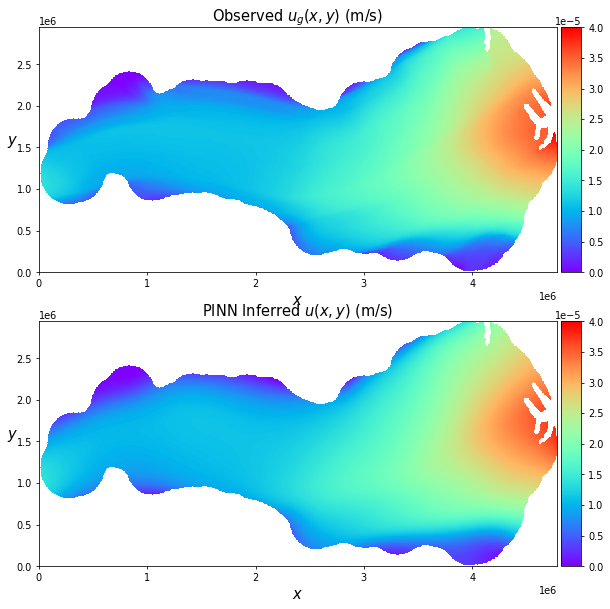

In [ ]:
u_g = results['u_g']
u = results['u']

xd = np.nan_to_num(xd, nan=0.0, posinf=0.0, neginf=0.0) # filter out nans/inf values
yd = np.nan_to_num(yd, nan=0.0, posinf=0.0, neginf=0.0)
# Get the shape of the grid
grid_shape = xd.shape  # or yd.shape, should be the same

# Reshape velocity data for plotting
u_g_reshaped = u_g.reshape(grid_shape)
u_reshaped = u.reshape(grid_shape)

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2, 1, 1)
h = ax.imshow(u_g_reshaped, interpolation='nearest', cmap='rainbow',
              extent=[xd.min(), xd.max(), yd.min(), yd.max()],
              origin='lower', aspect='auto', vmin=0, vmax=4e-5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15, rotation=0)
ax.set_title('Observed $u_g(x,y)$ (m/s)', fontsize=15)

ax2 = plt.subplot(2, 1, 2)
h2 = ax2.imshow(u_reshaped, interpolation='nearest', cmap='rainbow',
                extent=[xd.min(), xd.max(), yd.min(), yd.max()],
                origin='lower', aspect='auto', vmin=0, vmax=4e-5)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15, rotation=0)
ax2.set_title('PINN Inferred $u(x,y)$ (m/s)', fontsize=15)
fig.savefig(f"{output_dir}/u_comp.png", dpi=300, bbox_inches='tight')

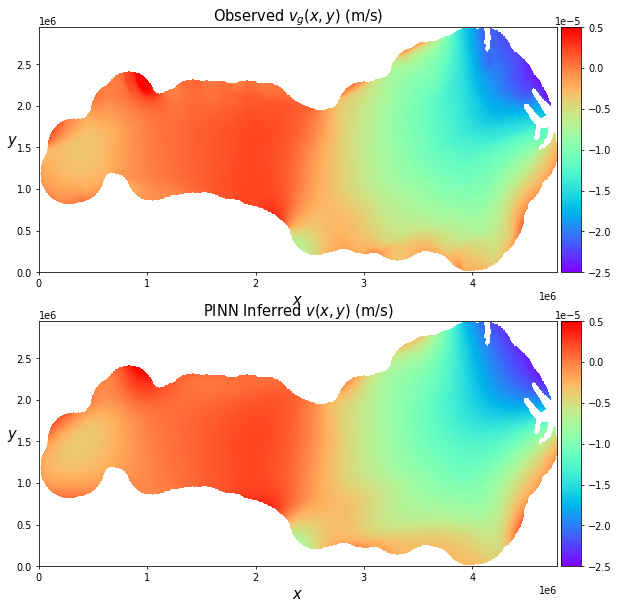

In [ ]:
v_g = results['v_g']
v = results['v']

xd = np.nan_to_num(xd, nan=0.0, posinf=0.0, neginf=0.0) # filter out nans/inf values
yd = np.nan_to_num(yd, nan=0.0, posinf=0.0, neginf=0.0)
# Get the shape of the grid
grid_shape = xd.shape  # or yd.shape, should be the same

# Reshape velocity data for plotting
v_g_reshaped = v_g.reshape(grid_shape)
v_reshaped = v.reshape(grid_shape)

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2, 1, 1)
h = ax.imshow(v_g_reshaped, interpolation='nearest', cmap='rainbow',
              extent=[xd.min(), xd.max(), yd.min(), yd.max()],
              origin='lower', aspect='auto', vmin=-2.5e-5, vmax=0.5e-5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15, rotation=0)
ax.set_title('Observed $v_g(x,y)$ (m/s)', fontsize=15)

ax2 = plt.subplot(2, 1, 2)
h2 = ax2.imshow(v_reshaped, interpolation='nearest', cmap='rainbow',
                extent=[xd.min(), xd.max(), yd.min(), yd.max()],
                origin='lower', aspect='auto', vmin=-2.5e-5, vmax=0.5e-5)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15, rotation=0)
ax2.set_title('PINN Inferred $v(x,y)$ (m/s)', fontsize=15)
fig.savefig(f"{output_dir}/v_comp.png", dpi=300, bbox_inches='tight')

In [ ]:
# calculate residual means: |e1|/|e11|, |e1|/|e12| etc and |e2|/|e21|
print("Mean |e1|/|e11|:", np.nanmean(np.abs(results['e1'])/np.abs(results['e11'])))
print("Mean |e1|/|e12|:", np.nanmean(np.abs(results['e1'])/np.abs(results['e12'])))
print("Mean |e1|/|e13|:", np.nanmean(np.abs(results['e1'])/np.abs(results['e13'])))
print("Mean |e2|/|e21|:", np.nanmean(np.abs(results['e2'])/np.abs(results['e21'])))
print("Mean |e2|/|e22|:", np.nanmean(np.abs(results['e2'])/np.abs(results['e22'])))
print("Mean |e2|/|e23|:", np.nanmean(np.abs(results['e2'])/np.abs(results['e23'])))

Mean |e1|/|e11|: 0.63852024
Mean |e1|/|e12|: 0.76256514
Mean |e1|/|e13|: 0.54608446
Mean |e2|/|e21|: 0.56421024
Mean |e2|/|e22|: 2.121705
Mean |e2|/|e23|: 0.45684588


In [ ]:
# plot residuals all together!

# Define keys and layout
residual_keys = ['e1', 'e11', 'e12', 'e13', 'e2', 'e21', 'e22', 'e23']
titles = [r'$e_1$', r'$e_{11}$', r'$e_{12}$', r'$e_{13}$',
          r'$e_2$', r'$e_{21}$', r'$e_{22}$', r'$e_{23}$']

# Prepare shared color scale
vmin, vmax = -1000, 1000  # consistent fixed scale for all residuals

# Create figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 8), dpi=100)
axs = axs.flatten()

# Loop through keys and plot each residual
for i, (key, title) in enumerate(zip(residual_keys, titles)):
    ax = axs[i]
    try:
        reshaped = results[key].reshape(grid_shape)
        im = ax.imshow(reshaped, interpolation='nearest', cmap='RdBu_r',
                       extent=[xd.min(), xd.max(), yd.min(), yd.max()],
                       origin='lower', aspect='auto',
                       vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    except Exception as e:
        ax.set_title(f"{key} (failed)")
        print(f"Failed to plot {key}: {e}")

# Shared colorbar on the right
# Create a new axis beside the last subplot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im, cax=cax)

# Tight layout and save
fig.suptitle("Residual Fields", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Leave space for colorbar and title
fig.savefig(f"{output_dir}/all_residuals_grid.png", dpi=300)
plt.show()
plt.close(fig)

Showing the inferred viscosity via PINNs for the ice shelf

Text(0.5, 1.0, 'Inferred viscosity $\\mu(x,y)$')

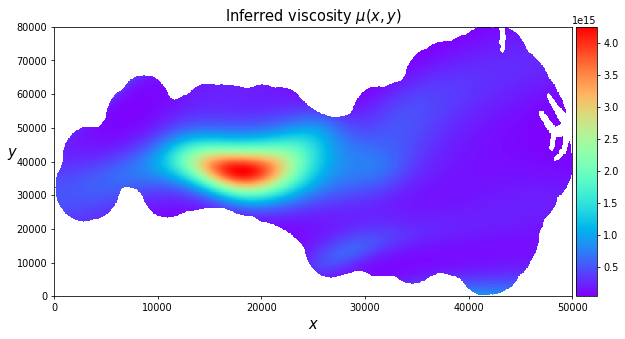

In [ ]:
# load the PINN inference of viscosity
mu = results['mu']
mu_reshaped = mu.reshape(grid_shape)

fig = plt.figure(figsize = [10, 5], dpi = 70)

ax = plt.subplot(1,1,1)
h = ax.imshow(mu_reshaped, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Inferred viscosity $\mu(x,y)$', fontsize = 15)
#fig.savefig(f"{output_dir}/inferred_visc_2.png", dpi=300, bbox_inches='tight')

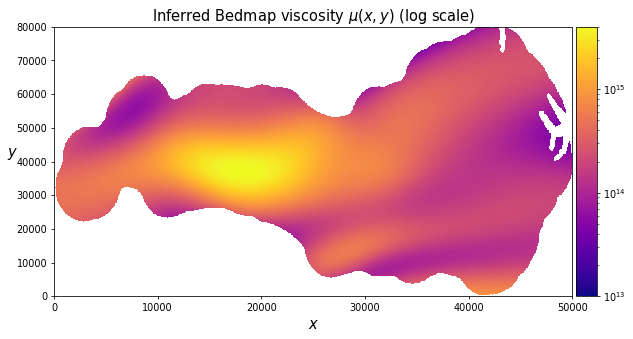

In [ ]:
# log-scaled colorbar for vicosity plot
# avoid log(0): set a small floor value
mu_reshaped = np.where(mu_reshaped <= 0, 1e-3, mu_reshaped)

fig = plt.figure(figsize=[10, 5], dpi=70)

ax = plt.subplot(1, 1, 1)

# Use LogNorm for color scaling
h = ax.imshow(mu_reshaped, interpolation='nearest', cmap='plasma',
              norm=LogNorm(vmin=1e13, vmax = 4e15), # , vmin=4e13, vmax = 4e15
              extent=[0., 50000., 0, 80000.],
              origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15, rotation=0)
ax.set_title('Inferred Bedmap viscosity $\\mu(x,y)$ (log scale)', fontsize=15)

fig.savefig(f"{output_dir}/inferred_visc_logscale_fixed.png", dpi=300, bbox_inches='tight')
plt.show()